## **Dataset description**
---
A list of over 7,000 electronic products with 10 fields of pricing information.

dataset link:
https://data.world/datafiniti/electronic-products-and-pricing-data<br>
field details:
https://developer.datafiniti.co/docs/product-data-schema

## **Brief analysis**
---

In [36]:
import pandas as pd
data = pd.read_csv('electronics_products.csv')
data.head(2)

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,USD,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,...,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,7.94E+11,32.8 pounds,NaN,NaN,NaN,NaN,NaN
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,In Stock,New,USD,2017-12-14T06:00:00Z,True,Walmart.com,Expedited,...,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,http://reviews.bestbuy.com/3545/4784804/review...,6.42E+11,14 pounds,NaN,NaN,NaN,NaN,NaN


In [37]:
data.to_csv("electronics_products.tsv", sep="\t", index=False)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   999 non-null    object 
 1   prices.amountMax     999 non-null    float64
 2   prices.amountMin     999 non-null    float64
 3   prices.availability  999 non-null    object 
 4   prices.condition     999 non-null    object 
 5   prices.currency      999 non-null    object 
 6   prices.dateSeen      999 non-null    object 
 7   prices.isSale        999 non-null    bool   
 8   prices.merchant      999 non-null    object 
 9   prices.shipping      560 non-null    object 
 10  prices.sourceURLs    999 non-null    object 
 11  asins                999 non-null    object 
 12  brand                999 non-null    object 
 13  categories           999 non-null    object 
 14  dateAdded            999 non-null    object 
 15  dateUpdated          999 non-null    obj

## **ElasticSearch steps**
---

### création d'un ingest node pipeline en se basant sur le processor csv

In [ ]:
curl -X PUT localhost:9200/_ingest/pipeline/electronics_products -H "Content-Type: application/json" -d '{
    "processors": [
    {
      "csv" : {
        "field" : "csv_line",
        "target_fields": ["id","prices.amountMax","prices.amountMin","prices.availability","prices.condition","prices.currency","prices.dateSeen","prices.isSale","prices.merchant","prices.shipping","prices.sourceURLs","asins","brand","categories","dateAdded","dateUpdated","ean","imageURLs","keys","manufacturer","manufacturerNumber","name","primaryCategories","sourceURLs","upc","weight","Unnamed: 26","Unnamed: 27","Unnamed: 28","Unnamed: 29","Unnamed: 30"]
      }
    }
  ]
}' | jq

### création de l'index et définition des settings (analysis / mappings / pipeline) depuis un fichier séparé

In [ ]:
curl -X PUT "localhost:9200/electronics_products" -H "Content-Type: application/json" -d @electronics_products.conf | jq

settings et analysis sections

* char filter
nous choisissons de ne pas en définir le champ text 'synthese' semble propre
* tokenizer
split sur la regexp "[ .,!?]"
* tokenizer filter
filtre sur les token des stopword french

extrait:<br><br>
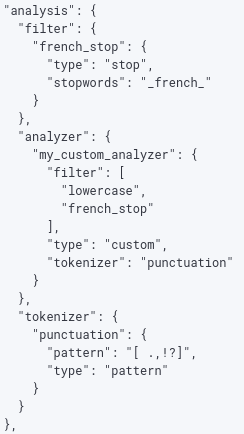

mappings section, extrait:<br><br>
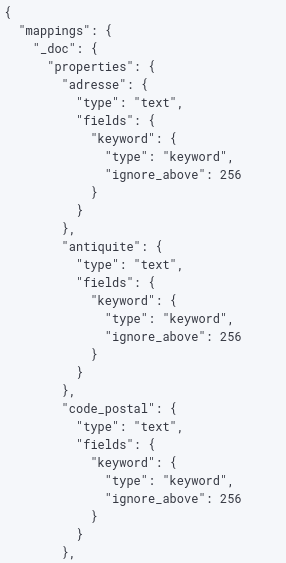

<BR>
les champs date_operation et geo_point_2d sont spécifiquement définis commes types date et geo_point:

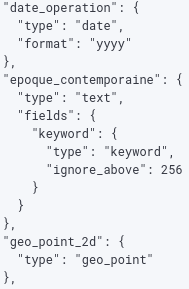

nous appliquons notre analyser au champ synthese

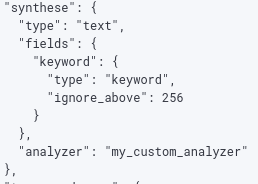

### insertion des données grace à un script élémentaire

In [ ]:
ingest electronics_products

In [ ]:
#!/bin/bash
echo "processing $1.csv"
while read f1
do
   curl -s -X POST "localhost:9200/$1/_doc" -H "Content-Type: application/json" -d "{ \"csv_line\": \"$f1\" }" > ingest.log
done < $1.csv

## **Exploration des données dans Kibana**
---

### création d'un pattern index Kibana le champ date_operation est détecté comme voulu de type date

### interface d'exploration et creation de premiers filtres, ici l'arrondissement

### rédaction de quelques queries dans Dev Tool

#### aggregation sur un scope limité pour exprimer une moyenne

In [ ]:
GET referentiel_archeologique_de_paris/_search
{
  "size": 0,
  "query": {
    "range": {
      "code_postal": {
        "gt": "75014"
      }
    }
  },
  "aggs": {
    "avg_operation_date": { "avg": { "field": "date_operation" } }
   }
}

#### buckets: la mojorité des opérations a lieu à partir du 19ème siècle

In [ ]:
GET referentiel_archeologique_de_paris/_search
{
  "size": 0,
  "aggs": {
    "dates": {
      "date_histogram": {
        "field": "date_operation",
        "fixed_interval": "30000d"
      } 
    }
   }
}

#### utilisation de regexp pour extraire la rue du Temple

In [ ]:
GET referentiel_archeologique_de_paris/_search
{
  "query": {
    "regexp": {
      "adresse": {
        "value": "temple",
        "flags": "ALL",
        "case_insensitive": true
      }
    }
  }
}